In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from ToyTrajectoryNet.losses import MMD_loss, OT_loss, Density_loss, Local_density_loss
from ToyTrajectoryNet.utils import group_extract, sample, to_np, generate_steps
from ToyTrajectoryNet.models import ToyModel, make_model, Autoencoder
from ToyTrajectoryNet.plots import plot_comparision, plot_losses
from ToyTrajectoryNet.train import train, train_ae
from ToyTrajectoryNet.constants import ROOT_DIR, DATA_DIR, NTBK_DIR, IMGS_DIR, RES_DIR
from ToyTrajectoryNet.datasets import (
    make_diamonds, make_swiss_roll, make_tree, make_eb_data, 
    make_dyngen_data, relabel_data
)
from ToyTrajectoryNet.ode import NeuralODE, ODEF
from ToyTrajectoryNet.geo import DiffusionDistance, old_DiffusionDistance
from ToyTrajectoryNet.exp import setup_exp
from ToyTrajectoryNet.eval import generate_plot_data

import os, pandas as pd, numpy as np, \
    seaborn as sns, matplotlib as mpl, matplotlib.pyplot as plt, \
    torch, torch.nn as nn
import random

from tqdm.notebook import tqdm
from phate import PHATE

# for geodesic learning
from sklearn.gaussian_process.kernels import RBF
from sklearn.manifold import MDS

os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

/home/solstice/Projects/ToyTrajectoryNet/ToyTrajectoryNet/datasets.py:152: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if n_sample is not 'all' and not phate:


# Run 1NN Metrics

In [3]:
from ToyTrajectoryNet.eval import calculate_nn, get_points_from_trajectories
from ToyTrajectoryNet.utils import generate_steps
import pickle

NOTE: all files saved as pickles and uploaded to https://drive.google.com/drive/u/1/folders/1VRnmS-nYfLBx2oorroiVZOn7jCS7ZdWj
and contain the original df and points

In [7]:
results = [
    {
        'file': os.path.expanduser('~/Downloads/petals-mioflow.npy'),
        'func': None,
        'method': 'mioflow',
        'dataset': 'petals',
        'which': 'generated'
    },
    {
        'file': os.path.expanduser('~/Downloads/generated_leave5.npy'),
        'func': None,
        'method': 'mioflow',
        'dataset': 'dyngen',
        'which': 'generated'
    },    
    {
        'file': os.path.expanduser('~/Downloads/petals_save (1).npy'),
        'func': lambda e: np.array(np.split(e[-1], 5)),
        'method': 'dsb',
        'dataset': 'petals',
        'which': 'generated'
    },
    {
        'file': os.path.expanduser('~/Downloads/dyngen_save (1).npy'),
        'func': lambda e: np.array(np.split(e[-1], 5)),
        'method': 'dsb',
        'dataset': 'dyngen',
        'which': 'generated'        
    },
    {
        'file': os.path.expanduser('~/Downloads/petals_trajnet.npy'),
        'func': None,
        'method': 'tjnet',
        'dataset': 'petals',
        'which': 'trajectories'        
    },
    {
        'file': os.path.expanduser('~/Downloads/dyngen_trajnet.npy'),
        'func': None,
        'method': 'tjnet',
        'dataset': 'dyngen',
        'which': 'trajectories'                
    }
]

datasets = {
    'petals': os.path.expanduser('~/Downloads/petals-df.pkl'),
    'dyngen': os.path.expanduser('~/Downloads/dyngen-df.pkl'),
}

for result in results:
    file = result['file']
    func = result['func']
    method = result['method']
    dataset = result['dataset']
    which = result['which']
    
    # load appropriate dataframe
    with open(datasets[dataset], 'rb') as f:
        df = pickle.load(f)
    
    # load appropraite file
    loaded = np.load(file)
    if func is not None:
        loaded = func(loaded)


    sample_key = 'samples'
    how = 'end'
    groups = sorted(df.samples.unique())
    _method = 'quartile'
    
    # set data
    gen = None
    traj = None
    if which == 'generated':
        gen = loaded
    else:
        traj = loaded


    save = os.path.expanduser(os.path.join(
        RES_DIR, '1nn', f'{dataset}_{method}.pkl'
    ))
    if not os.path.isdir(os.path.dirname(file)):
        os.makedirs(os.path.dirname(file))

    _time = calculate_nn(
        df, generated=gen, trajectories=traj,
        compare_to='time',
        how=how,
        k=1, groups=groups, sample_key=sample_key,
        method=_method
    )
    _any = calculate_nn(
        df, generated=gen, trajectories=traj,
        compare_to='any',
        how=how,
        k=1, groups=groups, sample_key=sample_key,
        method=_method
    )
    print(f'{method}[[{dataset}]]\n\t time {np.round(_time, 5)}\t any {np.round(_any, 5)}')
    with open(save, 'wb') as f:
        pickle.dump({
            'df': df,
            '1nn': {'time':_time, 'any':_any},
            'how': how,
            'generated': gen,
            'trajectories': traj
        }, f)

mioflow[[petals]]
	 time 0.09554	 any 0.06639
mioflow[[dyngen]]
	 time 1.16261	 any 1.15277
dsb[[petals]]
	 time 0.61764	 any 0.05041
dsb[[dyngen]]
	 time 3.47405	 any 0.49303
tjnet[[petals]]
	 time 2.76939	 any 2.1557
tjnet[[dyngen]]
	 time 4.2771	 any 0.61537


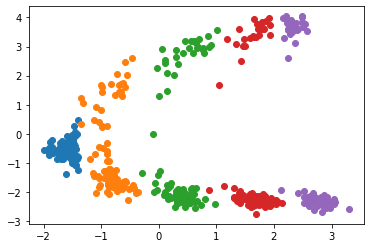

In [172]:
for g in l:#get_points_from_trajectories(5, l, 'end'):
    plt.scatter(g[:, 0], g[:, 1])